In [1]:
# Данные
import numpy as np
# Обучение
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
# Визуализация
import matplotlib.pyplot as plt
import IPython.display as display

In [4]:
def get_vgg_layers_model(layer_names):
    """ Функция принимает названия слоев и возвращает их из обученой модели VGG19 """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):

    """ Вычислении грам матрицы W*H*C. """
    
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    
    num_locations = tf.cast(input_shape[1]*input_shape[2]*input_shape[3], tf.float32)
    return result/(num_locations)

In [5]:
class StyleAndContentExtractor:
    def __init__(self, style_layers, content_layers): 
        """
        style_layers -- список имен слоев для стиля
        content_layers -- список имен слоев для контента
        """
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg_outputs_model = get_vgg_layers_model(style_layers + content_layers)
        self.vgg_outputs_model.trainable = False

    def __call__(self, inputs):
        # получает матрицу признаков по изображению
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255.)
        outputs = self.vgg_outputs_model(preprocessed_input)
        features_dict = {}

        style_layers_outputs = outputs[: len(self.style_layers)]
        content_layers_outputs = outputs[len(self.style_layers) :]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_layers_outputs]
        
        features_dict["style"] = {name:value for name, value in zip(self.style_layers, style_outputs)}
        features_dict["content"] = {name:value for name, value in zip(self.content_layers, content_layers_outputs)}
    
        return features_dict

In [9]:
# Собираем необходимые слои
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
content_layers = ['block4_conv2'] 

extractor = StyleAndContentExtractor(style_layers=style_layers, content_layers=content_layers)

80134624/80134624 [==============================] - 0s 0us/step


In [6]:
# Гиперпараметры для замены стиля(можно изменить в целях эксперемента)
style_weight = 100.0
content_weight = 5.0
tv_weight = 0.1

In [7]:
def style_content_loss(image, style_targets, content_targets): 
    """ Функция потерь """
    current_features = extractor(image) 

    style_loss = tf.add_n([tf.keras.losses.MeanSquaredError()(current_features['style'][name], style_targets[name]) for name in style_targets.keys()])
    content_loss = tf.add_n([tf.keras.losses.MeanSquaredError()(current_features['content'][name], content_targets[name]) for name in content_targets.keys()])

    loss = style_weight * style_loss + content_weight * content_loss + tv_weight * tf.image.total_variation(image)
    return loss

def loss(image):
    """ Функция передает функцию потерь в процесс обучения """
    return style_content_loss(image, style_targets, content_targets)

In [8]:
def train_step(image, loss_func, optimizer):
    """ Один шаг обучения """
    with tf.GradientTape() as tape: # "записываем" градиенты для дальнейшего использования
        loss = loss_func(image)
    grad = tape.gradient(loss, image) # dLoss/dImage
    optimizer.apply_gradients([(grad, image)]) # шаг градиентного спуск. в случае  GD: image = image - lambda*dLoss/dImage
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0) # нормализуем от 0 до 1
    #image.assign(image)
    return loss.numpy()

In [52]:
# Импорт изображений
style_image = plt.imread('/content/style.jpg')[None, ...] * 1/255
content_image = plt.imread('/content/content.jpg')[None, ...] * 1/255

# Отладка изображений
style_image = tf.image.convert_image_dtype(style_image[..., :3], tf.float32)
content_image = tf.image.convert_image_dtype(content_image, tf.float32)

# Получение матрицы признаков по слоям
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

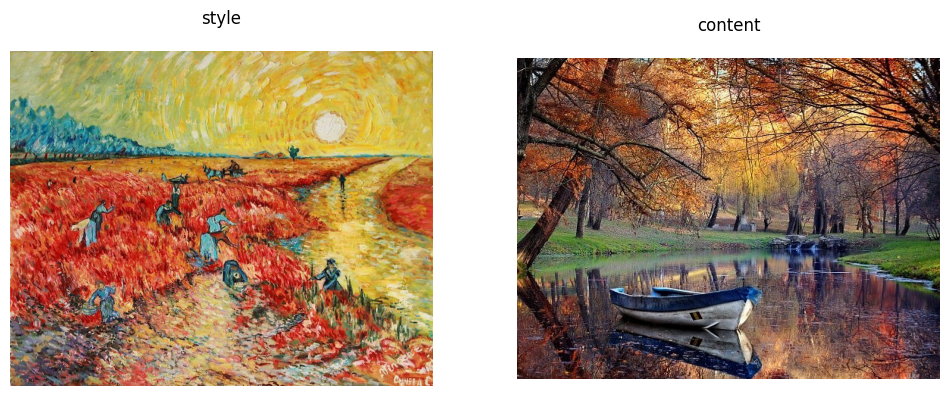

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (12, 20))
ax[0].imshow(style_image[0])
ax[0].set_title('style', pad = 20)
ax[1].imshow(content_image[0])
ax[1].set_title('content', pad = 20)

ax[0].axis('off')
ax[1].axis('off')
plt.show()

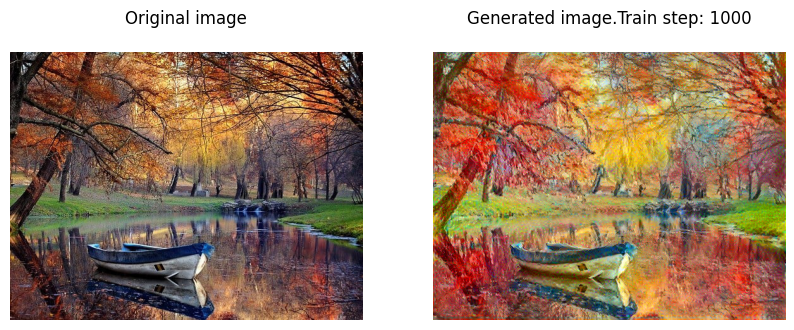

In [78]:
image = tf.Variable(content_image)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

epochs = 20
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image, loss_func=loss, optimizer=opt)

  display.clear_output(wait=True)

  fig, ax = plt.subplots(1, 2, figsize = (10, 18))

  ax[0].imshow(content_image[0])
  ax[0].set_title('Original image', pad = 20)
  ax[1].imshow(image[0])
  ax[1].set_title(f'Generated image.Train step: {step}', pad = 20)

  ax[0].axis('off')
  ax[1].axis('off')
  plt.show()

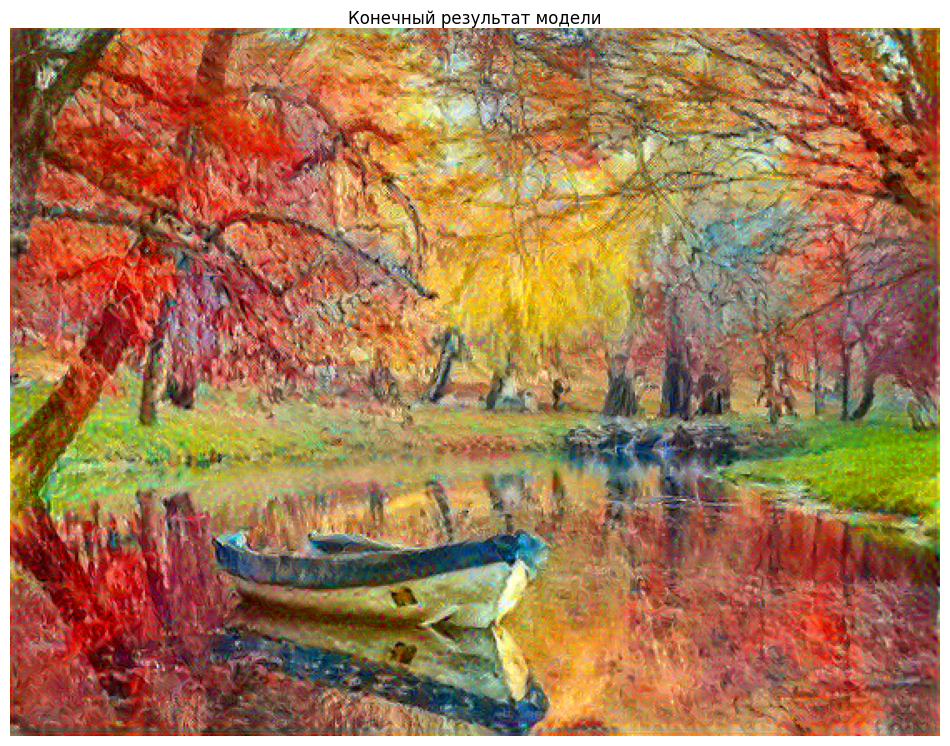

In [79]:
plt.subplots(figsize = (12, 12))
plt.imshow(image[0])
plt.title('Конечный результат модели', pad = 2)
plt.axis('off')
plt.show()